<a href="https://colab.research.google.com/github/Haniehnamavari/telegram_bot/blob/main/rnn_and_lstm_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/30



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 - 5s - 75ms/step - loss: 969894336.0000 - val_loss: 161625376.0000
Epoch 2/30
67/67 - 0s - 5ms/step - loss: 177601072.0000 - val_loss: 26338750.0000
Epoch 3/30
67/67 - 0s - 5ms/step - loss: 46979904.0000 - val_loss: 15982639.0000
Epoch 4/30
67/67 - 0s - 5ms/step - loss: 29233816.0000 - val_loss: 200699696.0000
Epoch 5/30
67/67 - 1s - 9ms/step - loss: 29964092.0000 - val_loss: 6808322.0000
Epoch 6/30
67/67 - 0s - 4ms/step - loss: 174884880.0000 - val_loss: 103930728.0000
Epoch 7/30
67/67 - 0s - 4ms/step - loss: 23891574.0000 - val_loss: 9796291.0000
Epoch 8/30
67/67 - 0s - 4ms/step - loss: 13589612.0000 - val_loss: 4009379.0000
Epoch 9/30
67/67 - 0s - 4ms/step - loss: 12354800.0000 - val_loss: 6012199.5000
Epoch 10/30
67/67 - 0s - 5ms/step - loss: 9522070.0000 - val_loss: 4668765.0000
Epoch 11/30
67/67 - 0s - 4ms/step - loss: 10380500.0000 - val_loss: 53077664.0000
Epoch 12/30
67/67 - 0s - 5ms/step - loss: 73159288.0000 - val_loss: 60183308.0000
Epoch 13/30
67/67 - 0s - 4ms/step -

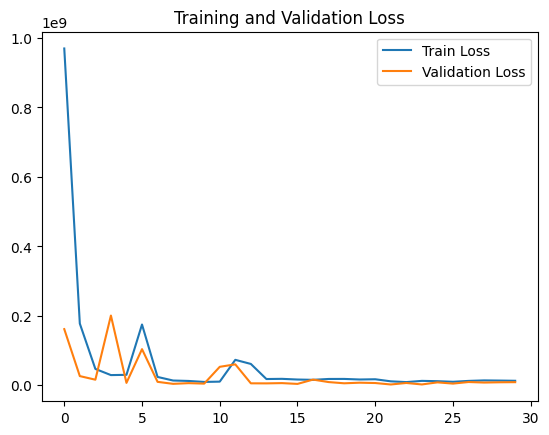

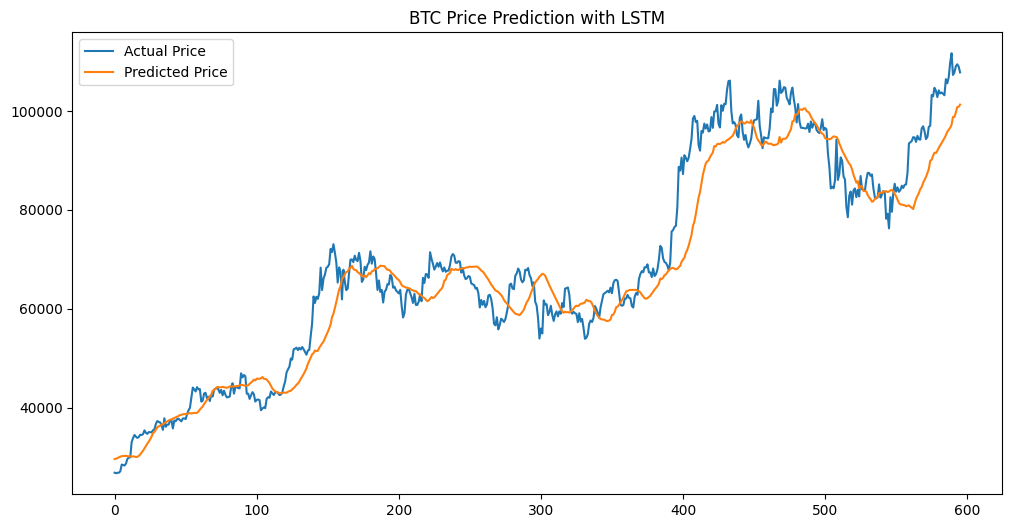

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


end_date = datetime.today()
start_date = end_date - timedelta(days=3000)

btc = yf.download("BTC-USD", start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
btc["Day"] = np.arange(1, len(btc)+1)
btc["Target"] = btc["Close"].shift(-1)


btc['Return'] = btc['Close'].pct_change()
btc.dropna(inplace=True)

features = ['Close', 'Day', 'Return']
data = btc[features].values
targets = btc['Target'].values


def create_sequences(data, targets, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = targets[i+seq_length]
        if np.isnan(y):
            continue
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20
X_seq, y_seq = create_sequences(data, targets, seq_length)


split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


model = Sequential([
    LSTM(64, activation='relu', input_shape=(seq_length, len(features))),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)


y_pred = model.predict(X_test).flatten()


mask = ~np.isnan(y_test) & ~np.isnan(y_pred)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

mse = mean_squared_error(y_test_clean, y_pred_clean)
print(f"LSTM Test MSE: {mse:.4f}")



plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_clean, label='Actual Price')
plt.plot(y_pred_clean, label='Predicted Price')
plt.legend()
plt.title('BTC Price Prediction with LSTM')
plt.show()
